# CNNÏùÑ Ïù¥Ïö©ÌïòÏó¨ cifar10 Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÎ•òÌïòÍ∏∞

keyword: CNN, convolution, pooling, vgg16, resnet50, pretrained model, transfer learning, fine tunning

- key wordÏóê ÎåÄÌï¥ÏÑú Ïù¥Ìï¥ÌïòÍ≥†, ÏàôÏßÄÌï†Í≤É

- 1. mnist datasetÏóêÏÑú ÏåìÏùÄ Í≤ΩÌóòÏúºÎ°ú, ÏûêÏú†Î°≠Í≤å Î™®Îç∏ÎßÅ Ìï†Í≤É
- 2. vggnetworkÎ•º Î∂àÎü¨ÏôÄÏÑú (img size 244,244Î°ú Ìï¥ÏïºÌï®) ÏÉàÎ°úÏö¥ layerÎ•º Ï∂îÍ∞ÄÌïòÍ≥†, Í∏∞Ï°¥Ïùò Î™®Îç∏ÏùÄ freezeÌï¥ÏÑú Ï∂îÍ∞ÄÌïôÏäµÏùÑ ÏßÑÌñâÌï†Í≤É

- 3. Î≥∏Ïù∏Ïùò Î∞©Î≤ïÍ≥º vggnetÏùò Í≤∞Í≥ºÎ•º ÎπÑÍµêÌïòÎ©∞, ÏµúÎåÄÌïú ÏÑ±Îä•ÏùÑ ÎπÑÏä∑ÌïòÍ≤å Ïó¨Îü¨Î∞©Î≤ïÏùÑ ÏÇ¨Ïö©Ìï¥ÏÑú ÏûêÏã†Ïù¥ Î™®Îç∏ÎßÅÌïúÍ≤ÉÎì§ÏùÑ ÏàòÏ†ïÌï¥Î≥ºÍ≤É.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [3]:
transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=12)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=12)

In [4]:

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


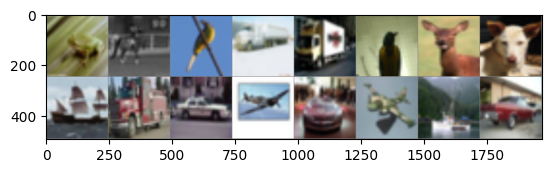

frog  horse bird  truck


In [6]:
# Ïã§ÌñâÌï†ÏàòÎ°ù Ï∂úÎ†•ÎêòÎäî Ïù¥ÎØ∏ÏßÄ Îã¨ÎùºÏßÄÎãà, Ïó¨Îü¨Î≤à Ïã§ÌñâÌï¥ÏÑú ÌôïÏù∏Ìï¥Î≥¥Ïûê
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# your code here

In [7]:
# ÎÇ¥ Î™®Îç∏ Ï†ïÏùò
import torch.nn.functional as F
class NeuralNetDeep(nn.Module):  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Ï∂îÍ∞ÄÏ∏µ
        self.pool = nn.MaxPool2d(2, 2)  # ÌíÄÎßÅ Ï∂îÍ∞Ä
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) #Ï∂îÍ∞ÄÏ∏µ
        self.fc1 = nn.Linear(3 * 244 * 244, 512) 
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [31]:
# VGGNet Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
num_classes = 10
from torchvision import models as tv_models

class VGG16Model(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        base = tv_models.vgg16(pretrained=True)
        
        self.features = base.features          # Conv blocks
        self.avgpool = base.avgpool            # AdaptiveAvgPool2d((7,7))
        
        for param in self.features.parameters():
            param.requires_grad = False        # Feature extractor freeze

        # ‚úÖ Custom classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),      # 25088 ‚Üí 1024
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        

        x = torch.flatten(x, 1)                # (B, 512, 7, 7) ‚Üí (B, 25088)
        x = self.classifier(x)
        return x

In [ ]:
# ÏÉàÎ°úÏö¥ Î∂ÑÎ•òÍ∏∞ Î†àÏù¥Ïñ¥Î•º VGGNet ÎÅùÎã®Ïóê Ï∂îÍ∞Ä


In [32]:
# ÏÜêÏã§Ìï®Ïàò, optimizer Îì±Îì± Ï†ïÏùò

models = {
    #"Baseline": NeuralNet,
    #"Dropout": NeuralNetDropout,
    #"BatchNorm": NeuralNetBatchNorm,
    "Deep": NeuralNetDeep,
    "VGG16": VGG16Model
}

optimizers = {
    "SGD": lambda model: optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
    #"Adam": lambda model: optim.Adam(model.parameters(), lr=0.001)
}


criterion = nn.CrossEntropyLoss()  # ÌÅ¨Î°úÏä§ ÏóîÌä∏Î°úÌîº ÏÜêÏã§ Ìï®Ïàò


In [33]:
# ÌïôÏäµ (ÎÇòÏùò Î™®Îç∏, vgg Î™®Îç∏ ÎëòÎã§ ÌïôÏäµÌï†Í≤É)

num_epochs = 10

def train_model(model, optimizer, train_loader, criterion, num_epochs=10):
    model.to(device)
    train_losses = []
    train_accuracies = []
    print("Epochs: ", num_epochs)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

    return train_losses, train_accuracies

def evaluate_model(model, test_loader, criterion):
    model.to(device)
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss = {avg_loss:.4f}, Test Accuracy = {accuracy:.2f}%")

    return avg_loss, accuracy

Using device: cuda

Training Deep with SGD


/home/peteryksong/.local/lib/python3.10/site-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Epochs:  10
Epoch 1: Loss = 2.1986, Accuracy = 20.68%
Epoch 2: Loss = 2.2161, Accuracy = 18.68%
Epoch 3: Loss = 2.2412, Accuracy = 16.35%
Epoch 4: Loss = 2.2301, Accuracy = 16.29%
Epoch 5: Loss = 2.2331, Accuracy = 15.82%
Epoch 6: Loss = 2.2223, Accuracy = 15.89%
Epoch 7: Loss = 2.1950, Accuracy = 17.12%
Epoch 8: Loss = 2.1847, Accuracy = 17.12%
Epoch 9: Loss = 2.1812, Accuracy = 17.10%
Epoch 10: Loss = 2.1750, Accuracy = 17.37%
Test Loss = 2.2044, Test Accuracy = 17.33%
Training Time: 605.01 seconds ‚è≥

Training VGG16 with SGD
Epochs:  10
Epoch 1: Loss = 0.7303, Accuracy = 75.30%
Epoch 2: Loss = 0.4779, Accuracy = 83.78%
Epoch 3: Loss = 0.3677, Accuracy = 87.47%
Epoch 4: Loss = 0.2844, Accuracy = 90.15%
Epoch 5: Loss = 0.2397, Accuracy = 91.67%
Epoch 6: Loss = 0.1962, Accuracy = 93.28%
Epoch 7: Loss = 0.1637, Accuracy = 94.48%
Epoch 8: Loss = 0.1446, Accuracy = 95.15%
Epoch 9: Loss = 0.1280, Accuracy = 95.68%
Epoch 10: Loss = 0.1139, Accuracy = 96.16%
Test Loss = 0.5448, Test Accurac

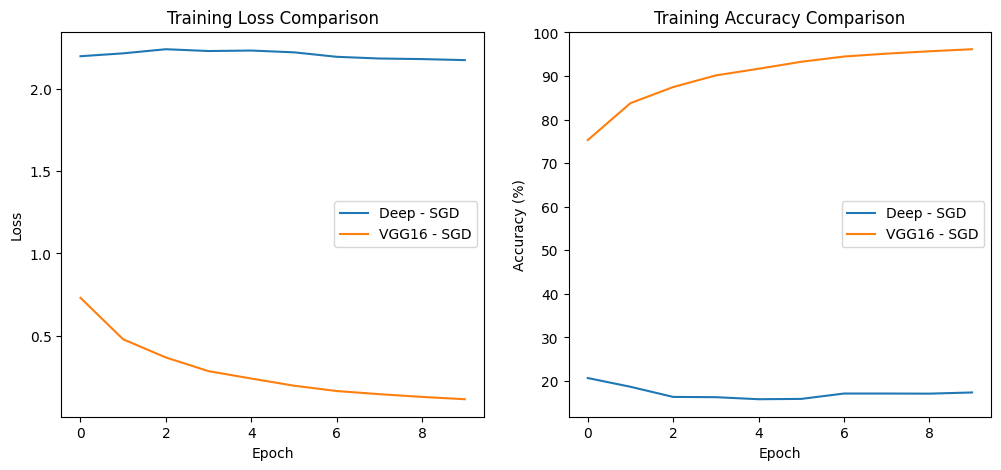

In [34]:
# Î≥∏Ïù∏Ïùò Î™®Îç∏Í≥º vggnetÏùò Í≤∞Í≥ºÎ•º ÎπÑÍµê
# plot result
import gc
import time  # ÏãúÍ∞Ñ Ï∏°Ï†ï
import seaborn as sns  # Í∑∏ÎûòÌîÑ ÏãúÍ∞ÅÌôî

# GPU ÏÑ§Ï†ï
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Print the selected device

results = {}

# Î™®Îì† Î™®Îç∏Ïùò Loss & AccuracyÎ•º ÌïòÎÇòÏùò Í∑∏ÎûòÌîÑÏóê Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
all_train_losses = {}
all_train_accuracies = {}

for model_name, model_class in models.items():
    for opt_name, opt_func in optimizers.items():
        print(f"\nTraining {model_name} with {opt_name}")

        # Í∏∞Ï°¥ Î™®Îç∏ Î∞è Î©îÎ™®Î¶¨ ÏôÑÏ†Ñ Ï¥àÍ∏∞Ìôî
        if 'model_instance' in locals():
            del model_instance  # Î™®Îç∏ Í∞ùÏ≤¥ ÏÇ≠Ï†ú
            gc.collect()  # Í∞ÄÎπÑÏßÄ Ïª¨Î†âÏÖò Ïã§Ìñâ

            if torch.cuda.is_available():  # GPU ÏÇ¨Ïö© ÏãúÎßå Ïã§Ìñâ
                torch.cuda.empty_cache()  # GPU Î©îÎ™®Î¶¨ Ï∫êÏãú ÎπÑÏö∞Í∏∞
                torch.cuda.ipc_collect()
                torch.cuda.reset_max_memory_allocated()  # GPU Î©îÎ™®Î¶¨ ÏÇ¨Ïö© Í∏∞Î°ù Ï¥àÍ∏∞Ìôî

        # ÏÉàÎ°úÏö¥ Î™®Îç∏ Î∞è ÏòµÌã∞ÎßàÏù¥Ï†Ä ÏÉùÏÑ±
        model_instance = model_class()  # ÏÉàÎ°úÏö¥ Î™®Îç∏ Ïù∏Ïä§ÌÑ¥Ïä§ ÏÉùÏÑ± (CPU)
        model_instance.to(device)  # Ïù¥ÌõÑÏóê GPUÎ°ú Ïù¥Îèô
        optimizer = opt_func(model_instance)  # ÏÉàÎ°úÏö¥ Optimizer ÏÑ§Ï†ï

        # ÌïôÏäµ ÏãúÍ∞Ñ Ï∏°Ï†ï ÏãúÏûë
        start_time = time.time()

        # ÌïôÏäµ Ïã§Ìñâ
        train_losses, train_accuracies = train_model(model_instance, optimizer, trainloader, criterion, num_epochs)

        # ÌïôÏäµ Ï¢ÖÎ£å ÏãúÍ∞Ñ Í∏∞Î°ù
        end_time = time.time()
        training_time = end_time - start_time  # ‚è≥ ÌïôÏäµ ÏÜåÏöî ÏãúÍ∞Ñ Í≥ÑÏÇ∞

        # ÌèâÍ∞Ä Ïã§Ìñâ
        test_loss, test_accuracy = evaluate_model(model_instance, testloader, criterion)

        # Í≤∞Í≥º Ï†ÄÏû•
        results[(model_name, opt_name)] = {
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "training_time": training_time  # ‚è≥ ÌïôÏäµ ÏãúÍ∞Ñ Ï†ÄÏû•
        }

        # Í∑∏ÎûòÌîÑ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• (Loss & Accuracy)
        label = f"{model_name} - {opt_name}"
        all_train_losses[label] = train_losses
        all_train_accuracies[label] = train_accuracies

        # ÌïôÏäµ ÏãúÍ∞Ñ Ï∂úÎ†•
        print(f"Training Time: {training_time:.2f} seconds ‚è≥")

# Loss & Accuracy Í∑∏ÎûòÌîÑ ÌÜµÌï© Ï∂úÎ†•
plt.figure(figsize=(12, 5))

# üîπ Training Loss Plot
plt.subplot(1, 2, 1)
for label, losses in all_train_losses.items():
    plt.plot(losses, label=label)
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# üîπ Training Accuracy Plot
plt.subplot(1, 2, 2)
for label, accuracies in all_train_accuracies.items():
    plt.plot(accuracies, label=label)
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()



# Í≤∞Í≥ºÏùò Ï∂úÎ†•

Using device: cuda  
  
Training Deep with Adam  
Epochs:  10  
Epoch 1: Loss = 2.1208, Accuracy = 27.72%  
Epoch 2: Loss = 1.9448, Accuracy = 28.53%  
Epoch 3: Loss = 1.9390, Accuracy = 28.01%  
Epoch 4: Loss = 1.9246, Accuracy = 28.42%  
Epoch 5: Loss = 1.9062, Accuracy = 28.79%  
Epoch 6: Loss = 1.9103, Accuracy = 29.17%  
Epoch 7: Loss = 1.8874, Accuracy = 29.91%  
Epoch 8: Loss = 1.8725, Accuracy = 30.07%  
Epoch 9: Loss = 1.8748, Accuracy = 30.29%  
Epoch 10: Loss = 1.8649, Accuracy = 30.84%  
Test Loss = 1.9889, Test Accuracy = 24.10%  
Training Time: 1133.16 seconds ‚è≥  
  
Training VGG16 with Adam  
Epochs:  10  
Epoch 1: Loss = 2.3303, Accuracy = 10.05%  
Epoch 2: Loss = 2.3062, Accuracy = 9.78%  
Epoch 3: Loss = 2.3050, Accuracy = 10.02%  
Epoch 4: Loss = 2.3048, Accuracy = 9.98%  
Epoch 5: Loss = 2.3043, Accuracy = 9.88%  
Epoch 6: Loss = 2.3038, Accuracy = 9.82%  
...  
Epoch 9: Loss = 2.3034, Accuracy = 9.78%  
Epoch 10: Loss = 2.3031, Accuracy = 10.12%  
Test Loss = 2.3027, Test Accuracy = 10.00%  
Training Time: 7903.00 seconds ‚è≥  
  
Ïö∞ÏÑ† Í≤∞Í≥º Î∂ÑÏÑù. 
1. Epoch Í∞Ä Ï†ÅÏùÄÍ∞Ä? (30~50ÍπåÏßÄ ÎäòÎ†§Î≥ºÍ≤ÉÏùÑ Í∂åÏû•Ìï®. )  -->Ï¥àÍ∏∞ Í≤ΩÌñ• Î≥¥Îäî Í≤ÉÏù¥Îãà 10ÏúºÎ°ú ÌïòÏûê. 
2. CNN Í∏∞Î≥∏ Î™®Îç∏Ïùò ÌïôÏäµÏú®Ïù¥ MNIST ÎåÄÎπÑÌï¥ÏÑú Ï†ÅÏùÄÎç∞,   
   1. 244x244 Îäî VGG Ïö©ÏûÑ. ÏùºÎ∞ò CNN ÏúºÎ°ú ÌïòÎ†§Î©¥ 32x32Î°ú Ìï¥Î≥¥ÎùºÍ≥† Ìï®. 
   2. ClassfierÏùò Î≥ÄÍ≤Ω. Í∏∞Ï°¥Ïóê Îã®Ïàú Î¶¨ÎãàÏñ¥ÏòÄÎäîÎç∞, Î†àÏù¥Ïñ¥ÏôÄ ÌíÄÎßÅÏùÑ Ï∂îÍ∞ÄÌï®. 
   3. freezeÎäî ÏÜêÎåÄÏßÄ ÏïäÏùå. 
   

In [23]:
import gc
gc.collect()
torch.cuda.empty_cache()

ÏµúÏ¢ÖÍ≤∞Í≥º 

Using device: cuda  
 
Training Deep with SGD  
/home/peteryksong/.local/lib/python3.10/site-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.  
  warnings.warn(  
Epochs:  10  
Epoch 1: Loss = 2.1986, Accuracy = 20.68%  
Epoch 2: Loss = 2.2161, Accuracy = 18.68%  
Epoch 3: Loss = 2.2412, Accuracy = 16.35%  
Epoch 4: Loss = 2.2301, Accuracy = 16.29%  
Epoch 5: Loss = 2.2331, Accuracy = 15.82%  
Epoch 6: Loss = 2.2223, Accuracy = 15.89%  
Epoch 7: Loss = 2.1950, Accuracy = 17.12%  
Epoch 8: Loss = 2.1847, Accuracy = 17.12%  
Epoch 9: Loss = 2.1812, Accuracy = 17.10%  
Epoch 10: Loss = 2.1750, Accuracy = 17.37%  
Test Loss = 2.2044, Test Accuracy = 17.33%  
Training Time: 605.01 seconds ‚è≥  

Training VGG16 with SGD  
Epochs:  10  
Epoch 1: Loss = 0.7303, Accuracy = 75.30%  
Epoch 2: Loss = 0.4779, Accuracy = 83.78%  
Epoch 3: Loss = 0.3677, Accuracy = 87.47%  
Epoch 4: Loss = 0.2844, Accuracy = 90.15%  
Epoch 5: Loss = 0.2397, Accuracy = 91.67%  
Epoch 6: Loss = 0.1962, Accuracy = 93.28%  
Epoch 7: Loss = 0.1637, Accuracy = 94.48%  
Epoch 8: Loss = 0.1446, Accuracy = 95.15%  
Epoch 9: Loss = 0.1280, Accuracy = 95.68%  
Epoch 10: Loss = 0.1139, Accuracy = 96.16%  
Test Loss = 0.5448, Test Accuracy = 86.34%  
Training Time: 2405.50 seconds ‚è≥  